<a href="https://colab.research.google.com/github/mjbooo/Pr4AI/blob/main/06_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![picture](https://drive.google.com/uc?id=1vC0N3Obk4HZJk9JOG7fKgYE10YYlCqsg)

# Week 6: Generative adversarial network (GAN) 

- We will cover basic concepts of GAN & implement vanilla GAN \[[Goodfellow et al., NIPS 2014](https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf)\]
- We will give basic skeletone code which include (1) training structure (2) sample visualization (3) FID evaluation
- You should implement (1) ***generator & discriminator architecture*** (2) ***noise sampling***  (3) ***GAN loss*** 
- Additionally, will give you [DCGAN](https://arxiv.org/abs/1511.06434) (basic GAN architecture) code that you can enjoy by your-self 



## 0. Preliminary

### 0.1. Prelim step 1: Load packages & GPU setup

In [ ]:
# visualize current GPU usages in your server
!nvidia-smi 

Sat May 15 05:21:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# set gpu by number 
import os
import random
os.environ['CUDA_VISIBLE_DEVICES'] = '0'  # setting gpu number

In [ ]:
# load packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import imageio #### install with "pip install imageio"
from IPython.display import HTML

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision.utils import make_grid

In [ ]:
# Create folders
if not os.path.exists('./checkpoint'):
    os.mkdir('./checkpoint')
    
if not os.path.exists('./dataset'):
    os.mkdir('./dataset')
    
if not os.path.exists('./img'):
    os.mkdir('./img')
    
if not os.path.exists('./img/real'):
    os.mkdir('./img/real')

if not os.path.exists('./img/fake'):
    os.mkdir('./img/fake')

### 0.2. Prelim step 2: Define visualization & image saving code

In [ ]:
# visualize the first image from the torch tensor
def vis_image(image):
    plt.imshow(image[0].detach().cpu().numpy(),cmap='gray')
    plt.show()

In [ ]:
def save_gif(training_progress_images, images):
    '''
        training_progress_images: list of training images generated each iteration
        images: image that is generated in this iteration
    '''
    img_grid = make_grid(images.data)
    img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
    img_grid = 255. * img_grid 
    img_grid = img_grid.astype(np.uint8)
    training_progress_images.append(img_grid)
    imageio.mimsave('./img/training_progress.gif', training_progress_images)
    return training_progress_images

In [ ]:
# visualize gif file
def vis_gif(training_progress_images):
    fig = plt.figure()
    
    ims = []
    for i in range(len(training_progress_images)):
        im = plt.imshow(training_progress_images[i], animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    
    html = ani.to_html5_video()
    HTML(html)

In [ ]:
# visualize gif file
def plot_gif(training_progress_images, plot_length=10):
    plt.close()
    fig = plt.figure()
    
    total_len = len(training_progress_images)
    for i in range(plot_length):
        im = plt.imshow(training_progress_images[int(total_len/plot_length)*i])
        plt.show()

In [ ]:
def save_image_list(dataset, real):
    if real:
        base_path = './img/real'
    else:
        base_path = './img/fake'
    
    dataset_path = []
    
    for i in range(len(dataset)):
        save_path =  f'{base_path}/image_{i}.png'
        dataset_path.append(save_path)
        vutils.save_image(dataset[i], save_path)
    
    return base_path

### 0.3. Prelim step 3: Load dataset, define dataloader

![picture](https://drive.google.com/uc?id=1kdig6RLSCvYJNqarbb8gviYsnxZfSkYQ)


In this class we will use **MNIST** (or you can use **Fashion-MNIST**) due to the time constraint :( \
You can practice with CIFAR-10 by your-self since dataset is already implemented inside PyTorch!
- Simply use `dataset=dset.CIFAR10(.)` function in PyTorch.
- If you are using CIFAR dataset, please note that the resolution is different to MNIST and should change model input dimension.

In [ ]:
dataset = dset.MNIST(root="./dataset", download=True,
                                   transform=transforms.Compose([
                                   transforms.ToTensor(),
                ]))
# If you want to download FMNIST use dset.FashionMNIST
# dataset = dset.FashionMNIST(.)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True, num_workers=2)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## 1. Define your generator & discriminator

### 1.1. Define generator module

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            #########################
            # Define your own generator #
            #########################
            
            nn.Linear(100, 256),# noise size=100 (100-dim Normal dist.)
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 784),
            nn.Sigmoid(),
            
            #########################
        )

    def forward(self, input):
        #####################################
        # Change the shape of output if necessary #
        
        #####################################
        
        output = self.main(input)
        
        #####################################
        # Change the shape of output if necessary #
        
        output = output.view(-1, 1, 28, 28)
        
        #####################################
        return output

### 1.2. Define discriminator module

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            ############################
            # Define your own discriminator #
            ############################
            
            nn.Linear(28*28, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid(),
            
            ############################
        )

    def forward(self, input):
        #####################################
        # Change the shape of output if necessary #
        input = input.view(-1, 28*28)
        #####################################
        
        output = self.main(input)
        
        #####################################
        # Change the shape of output if necessary #
        output = output.squeeze(dim=1)
        #####################################
        
        return output

### 1.3. Upload on GPU, define optimizer

In [ ]:
netG = Generator().cuda()
netD = Discriminator().cuda()

optimizerD = optim.Adam(netD.parameters(), lr=0.0002)
optimizerG = optim.Adam(netG.parameters(), lr=0.0002)

## 2. Noise sampling

In [ ]:
#### Implement here ####
noise = torch.randn(128, 100).cuda()  # noise size=100 (100-dim Normal dist.)
# torch.randn(m,n)= m*n mat of Standard Normal dist.

## 3. Train GAN

Implement GAN by filling out the following blankes!

In [ ]:
fixed_noise = torch.randn(128, 100).cuda()

criterion = nn.BCELoss()

n_epoch = 200
training_progress_images_list = []
for epoch in range(n_epoch):
    for i, (data, _) in enumerate(dataloader):
        ####################################################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z))) #
        ###################################################
        # train with real
        netD.zero_grad()
        data = data.cuda()
        batch_size = data.size(0)
        label = torch.ones((batch_size,)).cuda()
        output = netD(data)
        errD_real = criterion(output, label)
        D_x = output.mean().item()

        # train with fake
        noise = torch.randn(batch_size, 100).cuda()
        fake = netG(noise)
        label = torch.zeros((batch_size,)).cuda()
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        D_G_z1 = output.mean().item()
        
        # Loss backward
        errD = errD_real + errD_fake
        errD.backward()
        optimizerD.step()

        ########################################
        # (2) Update G network: maximize log(D(G(z))) #
        ########################################
        netG.zero_grad()
        label = torch.ones((batch_size,)).cuda()  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, label)
        D_G_z2 = output.mean().item()

        errG.backward()
        optimizerG.step()
        
    print('[%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f' 
              % (epoch, n_epoch, errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
    
    #save the output
    fake = netG(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, fake)  # Save fake image while training!
    
    # Check pointing for every epoch
    torch.save(netG.state_dict(), './checkpoint/netG_epoch_%d.pth' % (epoch))
    torch.save(netD.state_dict(), './checkpoint/netD_epoch_%d.pth' % (epoch))

[0/200] Loss_D: 0.0203 Loss_G: 5.8772 D(x): 0.9882 D(G(z)): 0.0071 / 0.0029
[1/200] Loss_D: 0.0067 Loss_G: 5.8968 D(x): 0.9978 D(G(z)): 0.0045 / 0.0028
[2/200] Loss_D: 0.0042 Loss_G: 7.7679 D(x): 0.9975 D(G(z)): 0.0015 / 0.0005
[3/200] Loss_D: 0.0011 Loss_G: 7.8700 D(x): 0.9997 D(G(z)): 0.0008 / 0.0004
[4/200] Loss_D: 0.0018 Loss_G: 7.3246 D(x): 0.9997 D(G(z)): 0.0015 / 0.0010
[5/200] Loss_D: 0.0091 Loss_G: 8.3205 D(x): 0.9996 D(G(z)): 0.0081 / 0.0011
[6/200] Loss_D: 0.0089 Loss_G: 7.2352 D(x): 0.9987 D(G(z)): 0.0073 / 0.0021
[7/200] Loss_D: 0.0111 Loss_G: 8.9345 D(x): 0.9985 D(G(z)): 0.0082 / 0.0015
[8/200] Loss_D: 0.0049 Loss_G: 7.6046 D(x): 0.9989 D(G(z)): 0.0038 / 0.0015
[9/200] Loss_D: 0.0027 Loss_G: 9.6645 D(x): 0.9991 D(G(z)): 0.0017 / 0.0006
[10/200] Loss_D: 0.0383 Loss_G: 8.5926 D(x): 0.9898 D(G(z)): 0.0023 / 0.0008
[11/200] Loss_D: 0.0065 Loss_G: 9.1932 D(x): 0.9994 D(G(z)): 0.0058 / 0.0010
[12/200] Loss_D: 0.0093 Loss_G: 9.8623 D(x): 0.9997 D(G(z)): 0.0084 / 0.0029
[13/200] 

## 4. Visualize/Plot your generated samples

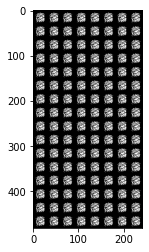

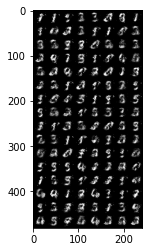

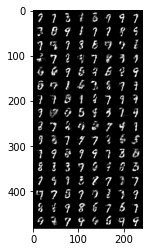

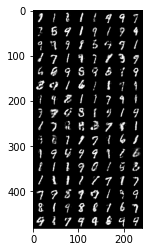

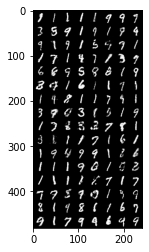

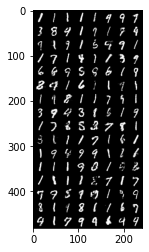

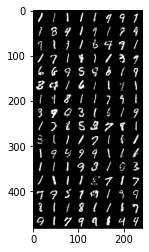

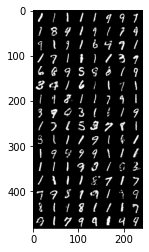

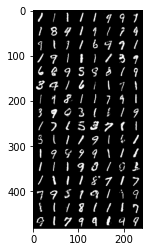

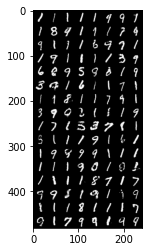

In [ ]:
#vis_gif(training_progress_images_list)
plot_gif(training_progress_images_list)

## Additional: DCGAN (try it by your-self)

There are various modern architectures of GAN e.g., DCGAN, SNGAN, and also training methods e.g., WGAN, gradient penulty

You can try the following architecture to improve the quality of generation!
- **Note that this version is for 64 by 64 resolution**

In [ ]:
nc = 3 # number of channels, RGB
nz = 100 # input noise dimension
ngf = 64 # number of generator filters
ndf = 64 #number of discriminator filters

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)

## Reference

PyTorch official DCGAN tutorial: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html \
github 1: https://github.com/Ksuryateja/DCGAN-CIFAR10-pytorch/blob/master/gan_cifar.py \
github 2: https://github.com/mseitzer/pytorch-fid \
FID score: https://github.com/mseitzer/pytorch-fid \
Inception score: https://github.com/sbarratt/inception-score-pytorch